In [24]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_data_template
from src.features.games import GameFeatures
from src.features.games_detailed import GameDetailedFeatures

In [25]:
data = load_data_template(season=False)
data.dropna(subset=['a_win'], inplace=True)
data.sample()

,Season,team_a,team_b,in_target,game_set,a_win,DayNum
10465,2006,1143,1301,False,0,False,137.0


In [26]:
game_feat = GameFeatures(default_lags=1)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_season, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_tourney, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_season_against_opponent, fillna=0, per_game=True)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_tourney_against_opponent, fillna=0, per_game=True)
game_detail_feat = GameDetailedFeatures(default_lags=3)
data = game_detail_feat.per_team_wrapper(data, game_detail_feat.detail_features_by_game, per_day=True)
data.dropna(inplace=True)
data.sample()

,Season,team_a,team_b,in_target,game_set,a_win,DayNum,games_won_in_season_team_a,games_won_in_season_team_a_lag-1,games_won_in_season_team_b,...,TO_game_team_b_lag-3,Stl_game_team_b_lag-1,Stl_game_team_b_lag-2,Stl_game_team_b_lag-3,Blk_game_team_b_lag-1,Blk_game_team_b_lag-2,Blk_game_team_b_lag-3,PF_game_team_b_lag-1,PF_game_team_b_lag-2,PF_game_team_b_lag-3
10269,2003,1237,1246,False,0,False,137,19,12.0,29,...,17.0,8.0,8.0,7.0,9.0,5.0,8.0,16.0,17.0,19.0


In [27]:
libfm_pred = pd.read_csv('data/libfm_model_out.csv', dtype={
    'team_a': str,
    'team_b': str,
    'Season': str
})
data = pd.merge(data, libfm_pred, on=['Season', 'team_a', 'team_b', 'DayNum'])\
    .rename(columns={'Pred': 'libfm_pred'}).drop('ID', axis=1)
data.head()

,Season,team_a,team_b,in_target,game_set,a_win,DayNum,games_won_in_season_team_a,games_won_in_season_team_a_lag-1,games_won_in_season_team_b,...,Stl_game_team_b_lag-1,Stl_game_team_b_lag-2,Stl_game_team_b_lag-3,Blk_game_team_b_lag-1,Blk_game_team_b_lag-2,Blk_game_team_b_lag-3,PF_game_team_b_lag-1,PF_game_team_b_lag-2,PF_game_team_b_lag-3,libfm_pred
0,2014,1107,1196,True,0,False,136,18,24.0,32,...,9.0,9.0,9.0,3.0,1.0,2.0,22.0,16.0,17.0,1.000000
1,2014,1107,1291,True,0,True,134,18,24.0,16,...,13.0,8.0,7.0,1.0,7.0,6.0,21.0,20.0,17.0,0.005842
2,2014,1110,1458,True,0,False,136,20,10.0,26,...,7.0,7.0,7.0,7.0,3.0,2.0,16.0,15.0,14.0,0.978630
3,2014,1112,1211,True,0,True,139,30,25.0,27,...,3.0,9.0,7.0,5.0,5.0,4.0,23.0,20.0,25.0,0.338499
4,2014,1112,1361,True,0,True,143,30,25.0,27,...,11.0,8.0,9.0,0.0,3.0,2.0,23.0,10.0,19.0,1.000000


In [28]:
knn_pred = pd.read_csv('data/knn_model_out.csv', dtype={
    'team_a': str,
    'team_b': str,
    'Season': str
})
data = pd.merge(data, knn_pred, on=['Season', 'team_a', 'team_b', 'DayNum'])\
    .rename(columns={'Pred': 'knn_pred'}).drop('ID', axis=1)
data.head()

,Season,team_a,team_b,in_target,game_set,a_win,DayNum,games_won_in_season_team_a,games_won_in_season_team_a_lag-1,games_won_in_season_team_b,...,Stl_game_team_b_lag-2,Stl_game_team_b_lag-3,Blk_game_team_b_lag-1,Blk_game_team_b_lag-2,Blk_game_team_b_lag-3,PF_game_team_b_lag-1,PF_game_team_b_lag-2,PF_game_team_b_lag-3,libfm_pred,knn_pred
0,2014,1107,1196,True,0,False,136,18,24.0,32,...,9.0,9.0,3.0,1.0,2.0,22.0,16.0,17.0,1.000000,0.866667
1,2014,1107,1291,True,0,True,134,18,24.0,16,...,8.0,7.0,1.0,7.0,6.0,21.0,20.0,17.0,0.005842,0.333333
2,2014,1110,1458,True,0,False,136,20,10.0,26,...,7.0,7.0,7.0,3.0,2.0,16.0,15.0,14.0,0.978630,0.066667
3,2014,1112,1211,True,0,True,139,30,25.0,27,...,9.0,7.0,5.0,5.0,4.0,23.0,20.0,25.0,0.338499,0.400000
4,2014,1112,1361,True,0,True,143,30,25.0,27,...,8.0,9.0,0.0,3.0,2.0,23.0,10.0,19.0,1.000000,0.266667


In [53]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


X = data.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target', 'DayNum'], axis=1)
y = data[['a_win', 'game_set']]

kf = KFold(n_splits=5, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i].a_win
    X_t, y_t = X.iloc[t_i], y.iloc[t_i].a_win
    xgb = XGBClassifier(max_depth=7, subsample=.8)
    xgb.fit(X_tr.values, y_tr)
    preds = xgb.predict_proba(X_t.values)
    ncaa_true = y.iloc[t_i][y.iloc[t_i].game_set == 0]
    ncaa_pred = preds[y.iloc[t_i].reset_index().game_set == 0]
    metric = log_loss(ncaa_true.a_win.astype(int), ncaa_pred)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))
# plt.figure(figsize=(20,4))
# plt.hist(metrics, bins=10)
# plt.show()

0.0953983511048284
0.11912755714788824
0.11168493009534693
0.10818077941283784
0.114602455856547
Metric Mean: 0.11 (0.01)


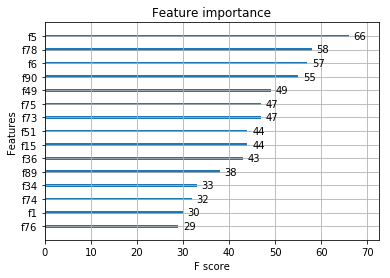

In [54]:
from xgboost import plot_importance

plot_importance(xgb, max_num_features=15)
plt.show()